# Métodos con base física

Los modelos con base física evalúan la ocurrencia de movimientos en masa en términos de factor de seguridad o probabilidades de ocurrencia, a través de modelos numéricos. Sin embargo existen diferentes aproximaciones a la física del problema con simplificaciones diferentes, por lo cual es fundamental utilizar el modelo que se ajuste a las necesidades o particularidades del área de estudio. Los métodos con base físisca son recomendables para áreas pequeñas a escalas detalladas, ya que requieren una gran cantidad de información de entrada, que se obtiene de ensayos de laboratorio o mediciones de campo. Por lo que la parametrización de los modelos puede ser complicada, en especial la distribución espacial de la profundidad del suelo, la cual juega un papel fundamental. Los modelos con base física permiten tener en consideración la complejidad de los factores detonantes (sismo y/o lluvia) y las características geomecánicas del terreno.

# Settings

In [25]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt

# Variables

Cohesion kN7/m2

Friccion rad

Permeailidad cm/h

Gamma kNm3

flowacum m2

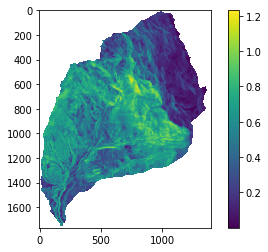

In [27]:
# Slope.

# Import Raster.
raster = rio.open('https://github.com/Dibarretot/CartografiaGeotecnica/blob/7c8c5e75a81d28924cf307fae782b644b8320f34/Taller3_InformacionSecundaria/AOI_SLOPE_Degree.tif?raw=true');
pendiente = raster.read(1);

# nan limits.
lowerSlopeLimit = 0;
upperSlpoeLimit = 90;

# Reclasify nan.
pendiente = np.where(pendiente < lowerSlopeLimit, np.nan, pendiente);
pendiente = np.where(pendiente > upperSlpoeLimit, np.nan, pendiente);

#To Rad
pendiente_rad = pendiente * 0.01745

# Render info.
plt.imshow(pendiente_rad)
plt.colorbar();


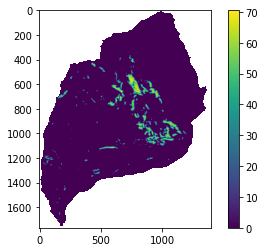

In [28]:
# espesor

profZ = pendiente

profZ = np.where(profZ < 15, 15, profZ);
profZ = np.where ( (np.logical_and (profZ>=15, profZ<50 )), -0.43*profZ + 21.43, profZ)
profZ = np.where(profZ < 50, 0, profZ);
espesor = profZ

plt.imshow(espesor)
plt.colorbar();

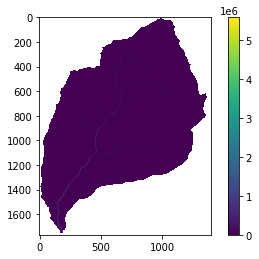

In [29]:
# Flow Accumulation

raster = rio.open('https://github.com/Dibarretot/CartografiaGeotecnica/blob/7c8c5e75a81d28924cf307fae782b644b8320f34/Taller3_InformacionSecundaria/AOI_FLOWACC.tif?raw=true')
flujo=raster.read(1)

# Mask
raster_mask = rio.open('https://github.com/Dibarretot/CartografiaGeotecnica/blob/7c8c5e75a81d28924cf307fae782b644b8320f34/Taller3_InformacionSecundaria/AOI_SLOPE_Degree.tif?raw=true');
msk=raster_mask.read_masks(1);
msk=np.where(msk == 255, 1, np.nan);
flujo = msk * flujo;

flujo=np.where(flujo<0,np.nan,flujo)
flujo=flujo*4 #area

plt.imshow(flujo)
plt.colorbar()

In [30]:
GammaW = 9.81
dx = 2 #cell size
q = 100 #mm/h

(1768, 1394)
[ 1.  2.  3. nan]


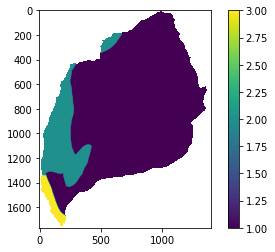

In [31]:
# Geology.

# Import Raster.
raster = rio.open('https://github.com/Dibarretot/CartografiaGeotecnica/blob/7c8c5e75a81d28924cf307fae782b644b8320f34/Taller3_InformacionSecundaria/AOI_GEO.tif?raw=true');
geologia = raster.read(1);
print(np.shape(geologia));

# Mask
raster_mask = rio.open('https://github.com/Dibarretot/CartografiaGeotecnica/blob/7c8c5e75a81d28924cf307fae782b644b8320f34/Taller3_InformacionSecundaria/AOI_SLOPE_Degree.tif?raw=true');
msk=raster_mask.read_masks(1);
msk=np.where(msk == 255, 1, np.nan);
geologia = msk * geologia;

# nan limits.
lowerGeologyLimit = 1;
upperGeologyLimit = 3;

# Reclasify nan.
geologia = np.where(geologia < lowerGeologyLimit, np.nan, geologia);
geologia = np.where(geologia > upperGeologyLimit, np.nan, geologia);

# Render info.
print(np.unique(geologia));
plt.imshow(geologia);
plt.colorbar();

In [32]:
ks = geologia
friccion = geologia
cohesion = geologia
peso = geologia

ks = np.where(ks == 1, 0.15, ks);
ks = np.where(ks == 2, 0.18, ks);
ks = np.where(ks == 3, 0.2, ks);

friccion = np.where(friccion == 1, 28 * 0.01745, friccion);
friccion = np.where(friccion == 2, 27 * 0.01745, friccion);
friccion = np.where(friccion == 3, 31 * 0.01745, friccion);

cohesion = np.where(cohesion == 1, 23, cohesion);
cohesion = np.where(cohesion == 2, 25, cohesion);
cohesion = np.where(cohesion == 3, 24, cohesion);

peso = np.where(peso == 1, 20, peso);
peso = np.where(peso == 2, 17, peso);
peso = np.where(peso == 3, 19, peso);

# Process

In [33]:
"STABILITY ANALYSIS"

MatEst = np.zeros(raster.shape)
Matq   = np.zeros(raster.shape)

M4=flujo/dx
M5=((0.01 * ks * (espesor * np.cos(pendiente)) * np.sin(pendiente)) / (0.001*q)) * ((peso / GammaW) * (1 - np.tan(pendiente) / np.tan(friccion)) + (cohesion / (GammaW * espesor * np.cos(pendiente)**2 * np.tan(friccion)))) 
MatEst1=np.where(M4>M5,3,MatEst) #  unstable

MatEst2=np.where(M4<=M5,4,MatEst1) # Stable

M1=np.tan(pendiente)
M2=(1 - (GammaW/peso)) * np.tan(friccion) + (cohesion / (peso * espesor * np.cos(pendiente)**2))
MatEst3  =np.where(M1<M2,1,MatEst2) # Unconditionally stable
	
M3=np.tan(friccion) + (cohesion / (peso * espesor * np.cos(pendiente)**2))
MatEst4  =  np.where(M1>=M3,2,MatEst3) # Unconditionally Unstable

Matq = (1000 * 0.01 * ks * espesor * np.cos(pendiente) * np.sin(pendiente)) * (dx / flujo) * ((peso / GammaW) * (1 - (np.tan(pendiente) / np.tan(friccion))) + cohesion / (GammaW * espesor * np.cos(pendiente)**2 * np.tan(friccion)))
np.nanmin(Matq)

MatEst=np.where(MatEst4 == 0, np.nan,MatEst4)
Matq=np.where(Matq==np.inf,np.nanmax(Matq[Matq!=np.inf]),Matq)

Matq = np.where(M1<M2,-1,np.where(M1>=M3,-2,Matq))

<ipython-input-33-ed59e4226f40>:7: RuntimeWarning: divide by zero encountered in true_divide
  M5=((0.01 * ks * (espesor * np.cos(pendiente)) * np.sin(pendiente)) / (0.001*q)) * ((peso / GammaW) * (1 - np.tan(pendiente) / np.tan(friccion)) + (cohesion / (GammaW * espesor * np.cos(pendiente)**2 * np.tan(friccion))))
<ipython-input-33-ed59e4226f40>:7: RuntimeWarning: invalid value encountered in multiply
  M5=((0.01 * ks * (espesor * np.cos(pendiente)) * np.sin(pendiente)) / (0.001*q)) * ((peso / GammaW) * (1 - np.tan(pendiente) / np.tan(friccion)) + (cohesion / (GammaW * espesor * np.cos(pendiente)**2 * np.tan(friccion))))
<ipython-input-33-ed59e4226f40>:13: RuntimeWarning: divide by zero encountered in true_divide
  M2=(1 - (GammaW/peso)) * np.tan(friccion) + (cohesion / (peso * espesor * np.cos(pendiente)**2))
<ipython-input-33-ed59e4226f40>:16: RuntimeWarning: divide by zero encountered in true_divide
  M3=np.tan(friccion) + (cohesion / (peso * espesor * np.cos(pendiente)**2))
<ipyth

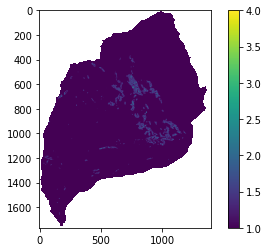

In [34]:
plt.imshow(MatEst)
plt.colorbar()

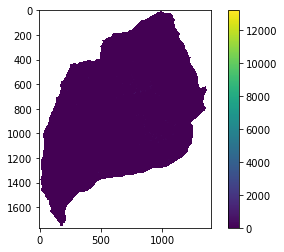

In [35]:
plt.imshow(Matq)
plt.colorbar()

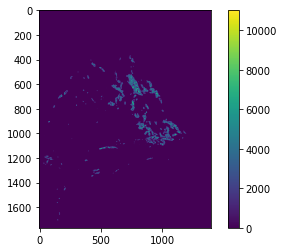

In [36]:
Vol = np.where(np.logical_or(MatEst==2, MatEst==3), espesor*12.5*12.5, 0)

with rio.open('Vol.tif', 'w', 
              driver='Gtiff',height=raster.shape[0],width=raster.shape[1],count=1,
              dtype='float64',nodata=-999,crs=raster.crs,transform=raster.transform) as dst:
    dst.write(Vol,1) 

plt.imshow(Vol)
plt.colorbar()